Brak pliku modelu – rozpoczynam trening.
Analiza zdjecia: 01
Ekstrakcja cech i etykiet z obrazu
Analiza zdjecia: 02
Ekstrakcja cech i etykiet z obrazu
Analiza zdjecia: 03
Ekstrakcja cech i etykiet z obrazu
Analiza zdjecia: 04
Ekstrakcja cech i etykiet z obrazu
Analiza zdjecia: 05
Ekstrakcja cech i etykiet z obrazu
Analiza zdjecia: 06
Ekstrakcja cech i etykiet z obrazu
Analiza zdjecia: 07
Ekstrakcja cech i etykiet z obrazu
Analiza zdjecia: 08
Ekstrakcja cech i etykiet z obrazu
Analiza zdjecia: 09
Ekstrakcja cech i etykiet z obrazu
Analiza zdjecia: 10
Ekstrakcja cech i etykiet z obrazu
Fitting model
Train test split
Starting RandomizedSearchCV
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params found: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 746}
Best CV accuracy: 0.8990887604932226
Test accuracy: 0.8976413898047172

Processed image: 11
Maksymalna wartość w predykcji: 1
Maksymalna wartość w masce eksperc

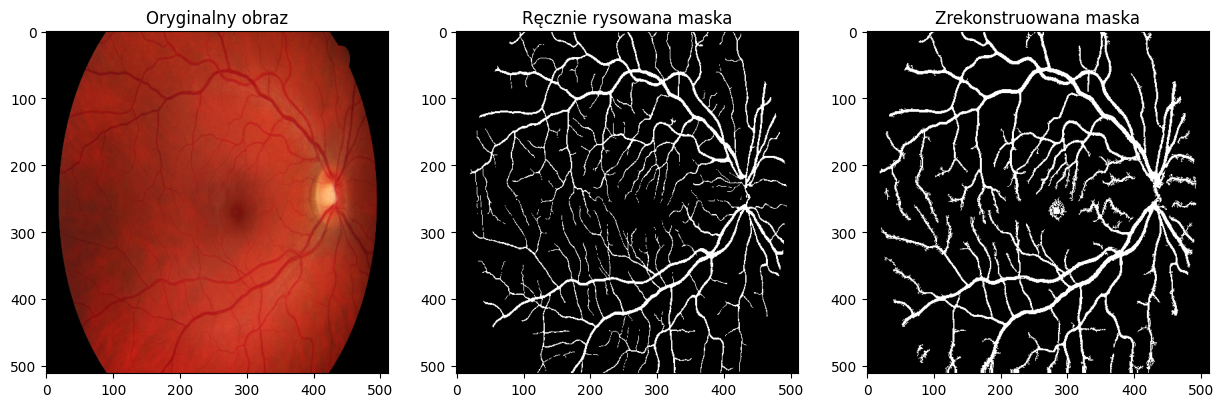

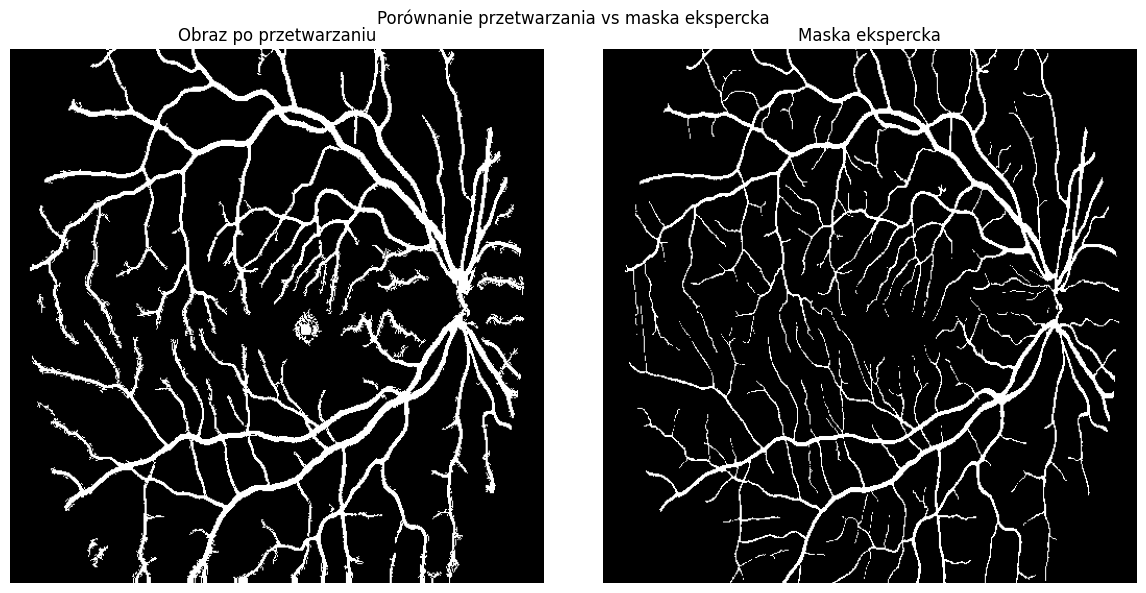

| Method     |   Accuracy |   Sensitivity |   Specificity |   Balanced Accuracy |   G-Mean |
|:-----------|-----------:|--------------:|--------------:|--------------------:|---------:|
| Normalized |     0.8689 |        0.4849 |        0.9085 |              0.6967 |   0.6637 |


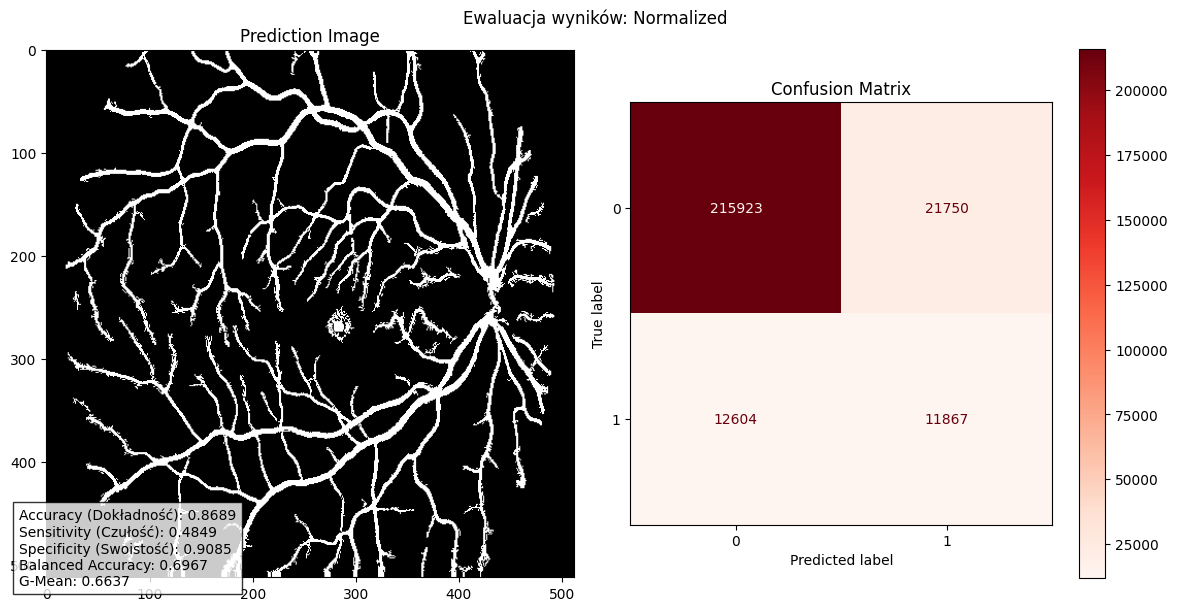


Processed image: 12
Maksymalna wartość w predykcji: 1
Maksymalna wartość w masce eksperckiej: True


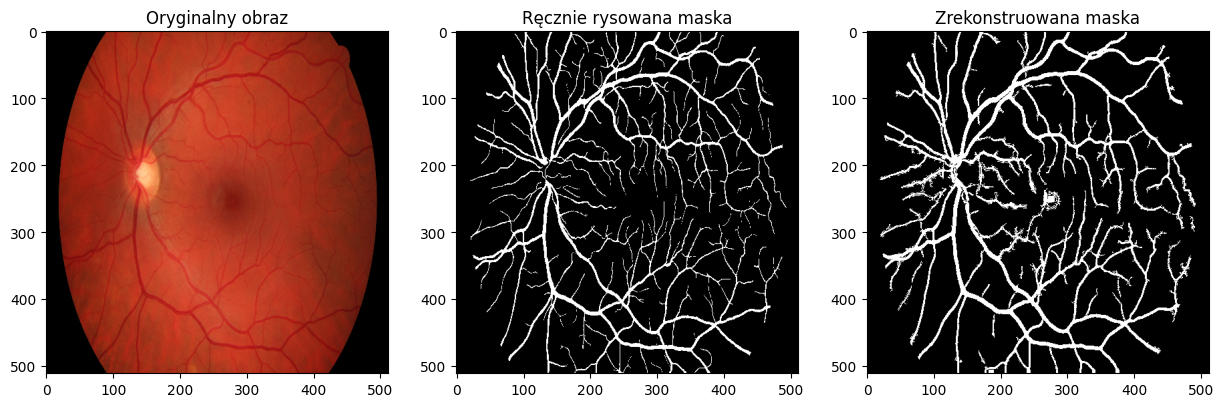

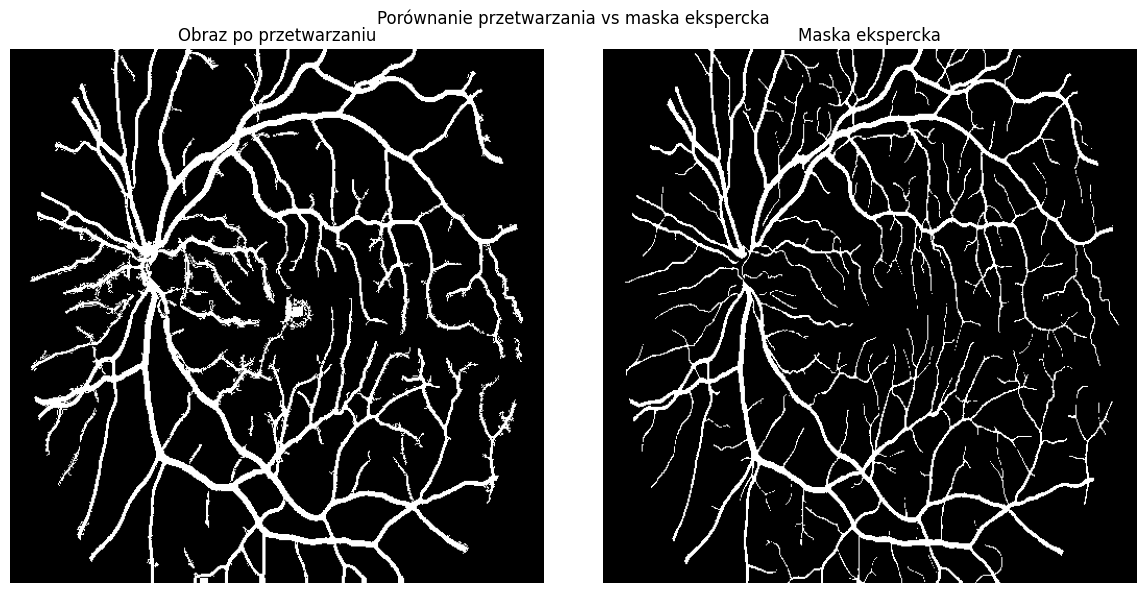

| Method     |   Accuracy |   Sensitivity |   Specificity |   Balanced Accuracy |   G-Mean |
|:-----------|-----------:|--------------:|--------------:|--------------------:|---------:|
| Normalized |     0.8627 |        0.5025 |        0.9048 |              0.7036 |   0.6743 |


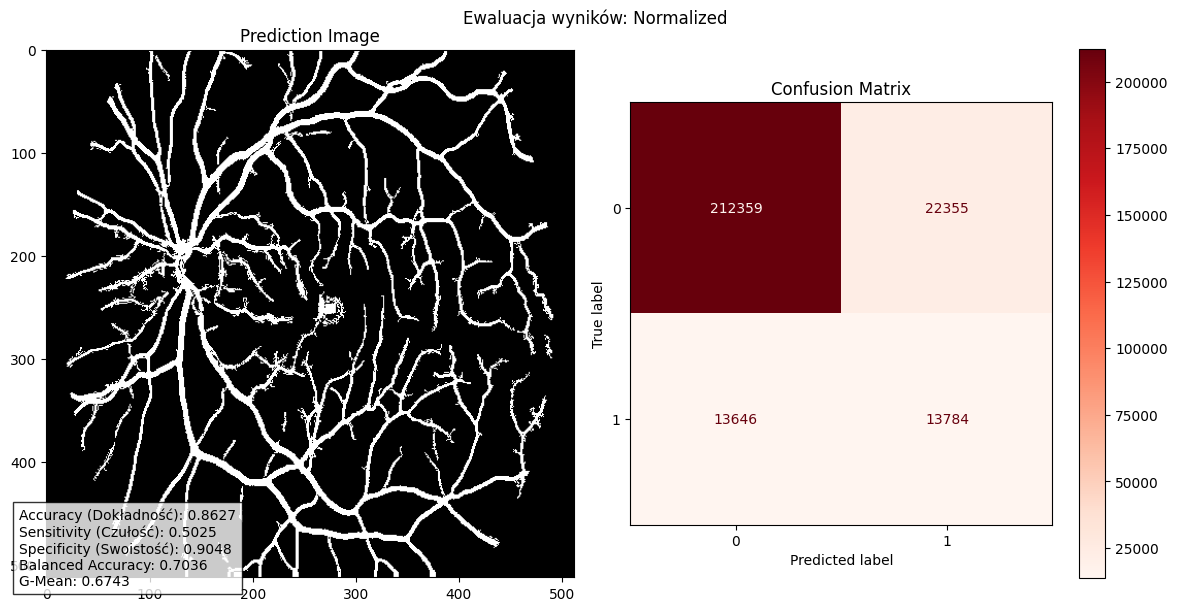


Processed image: 13
Maksymalna wartość w predykcji: 1
Maksymalna wartość w masce eksperckiej: True


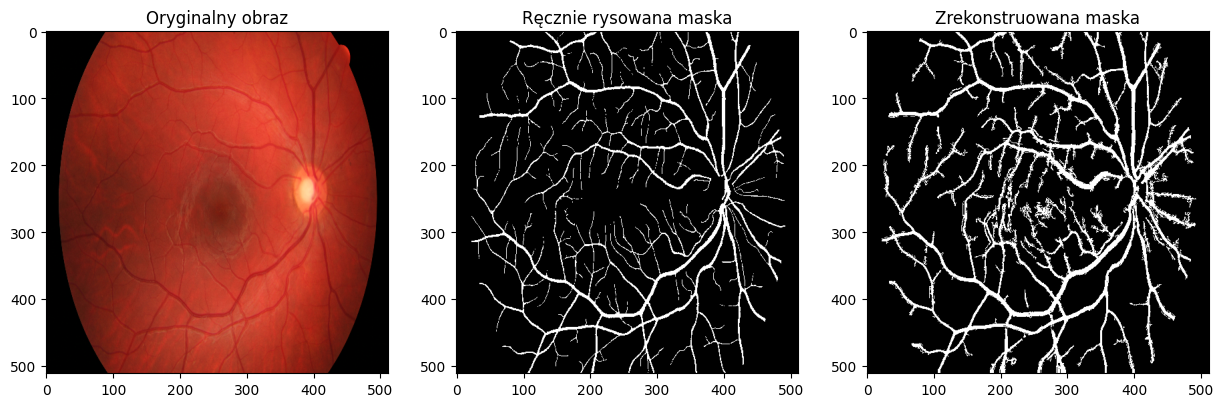

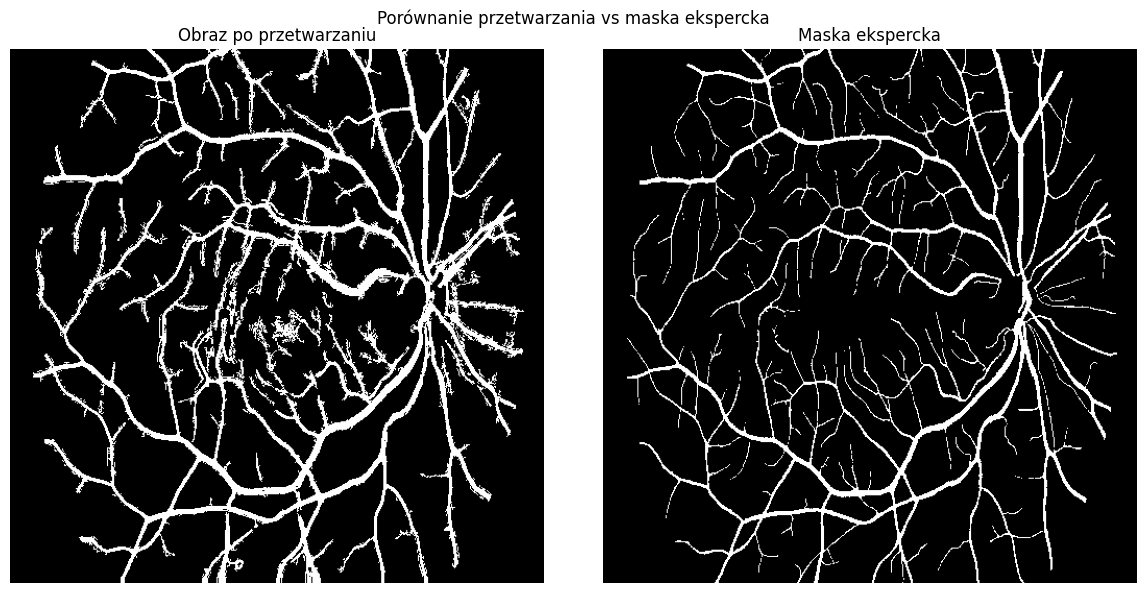

| Method     |   Accuracy |   Sensitivity |   Specificity |   Balanced Accuracy |   G-Mean |
|:-----------|-----------:|--------------:|--------------:|--------------------:|---------:|
| Normalized |     0.8622 |         0.537 |        0.8932 |              0.7151 |   0.6925 |


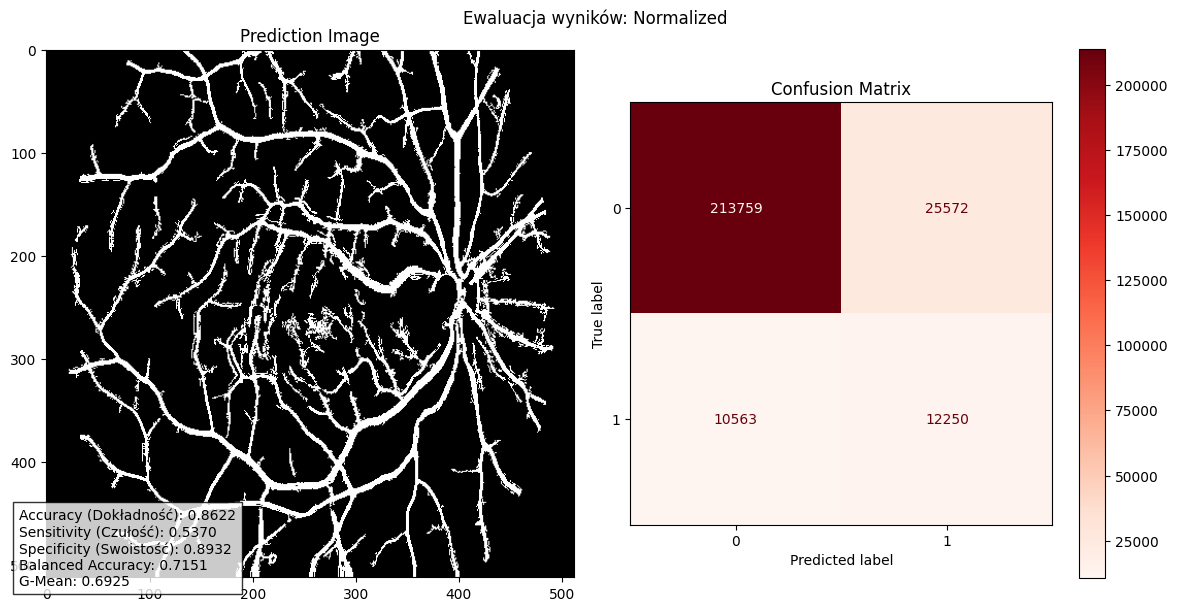


Processed image: 14
Maksymalna wartość w predykcji: 1
Maksymalna wartość w masce eksperckiej: True


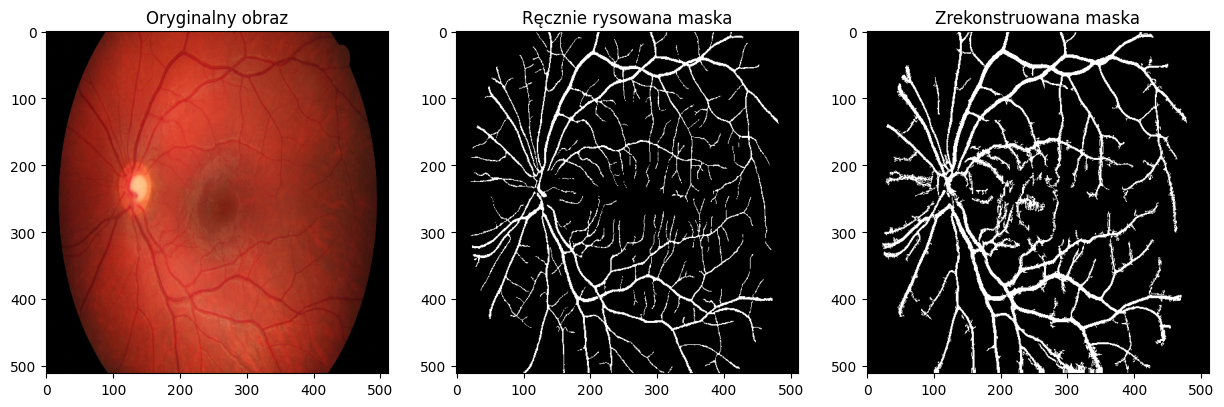

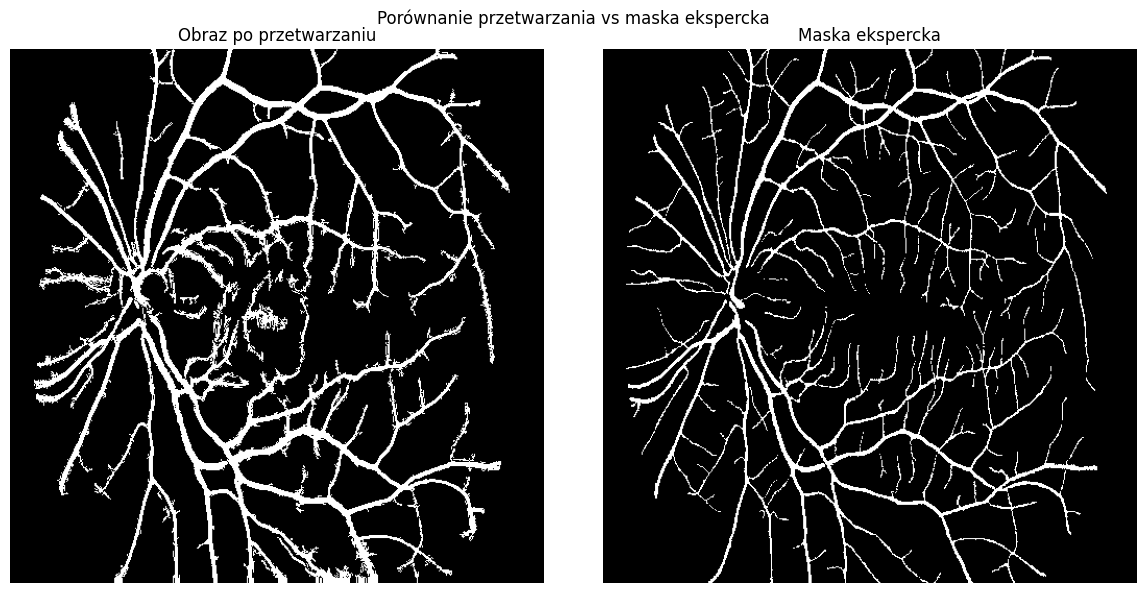

| Method     |   Accuracy |   Sensitivity |   Specificity |   Balanced Accuracy |   G-Mean |
|:-----------|-----------:|--------------:|--------------:|--------------------:|---------:|
| Normalized |      0.868 |        0.5158 |        0.9015 |              0.7087 |   0.6819 |


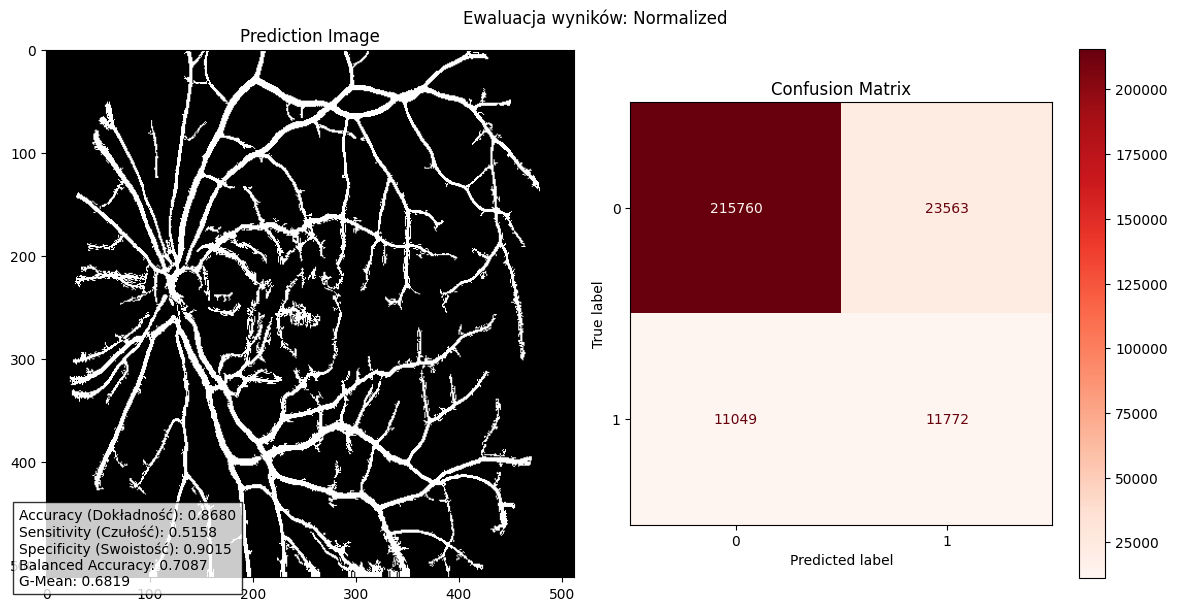


Processed image: 15
Maksymalna wartość w predykcji: 1
Maksymalna wartość w masce eksperckiej: True


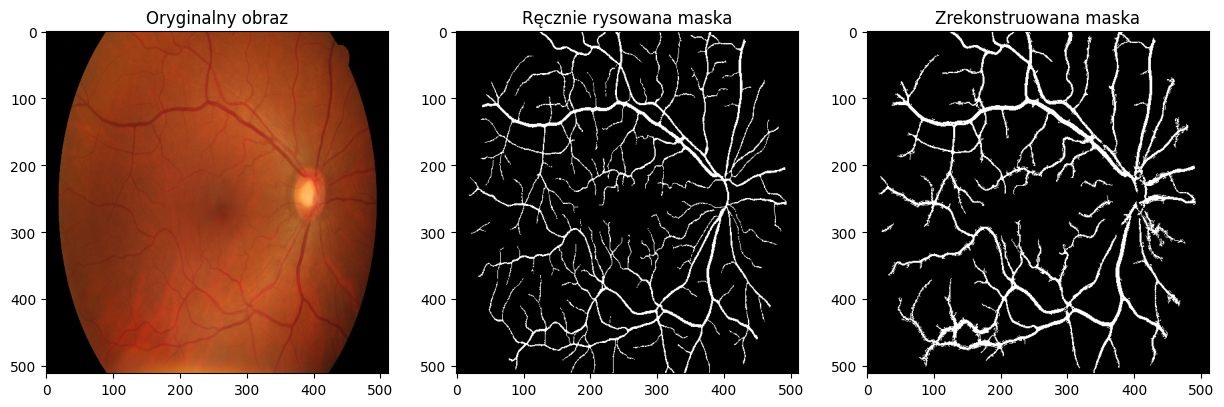

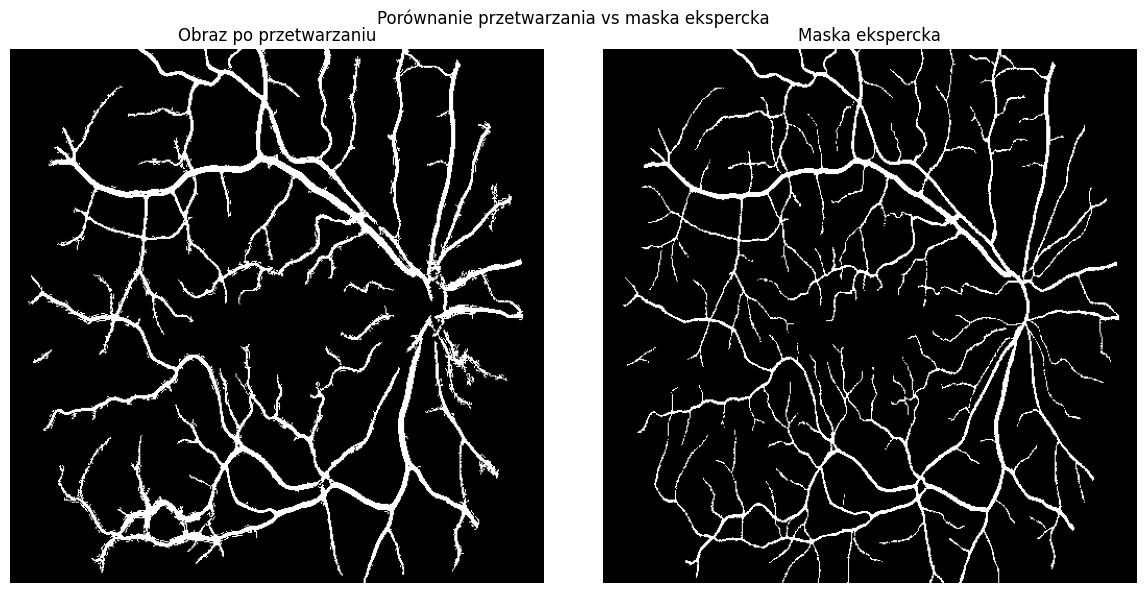

| Method     |   Accuracy |   Sensitivity |   Specificity |   Balanced Accuracy |   G-Mean |
|:-----------|-----------:|--------------:|--------------:|--------------------:|---------:|
| Normalized |     0.8916 |        0.4602 |        0.9284 |              0.6943 |   0.6536 |


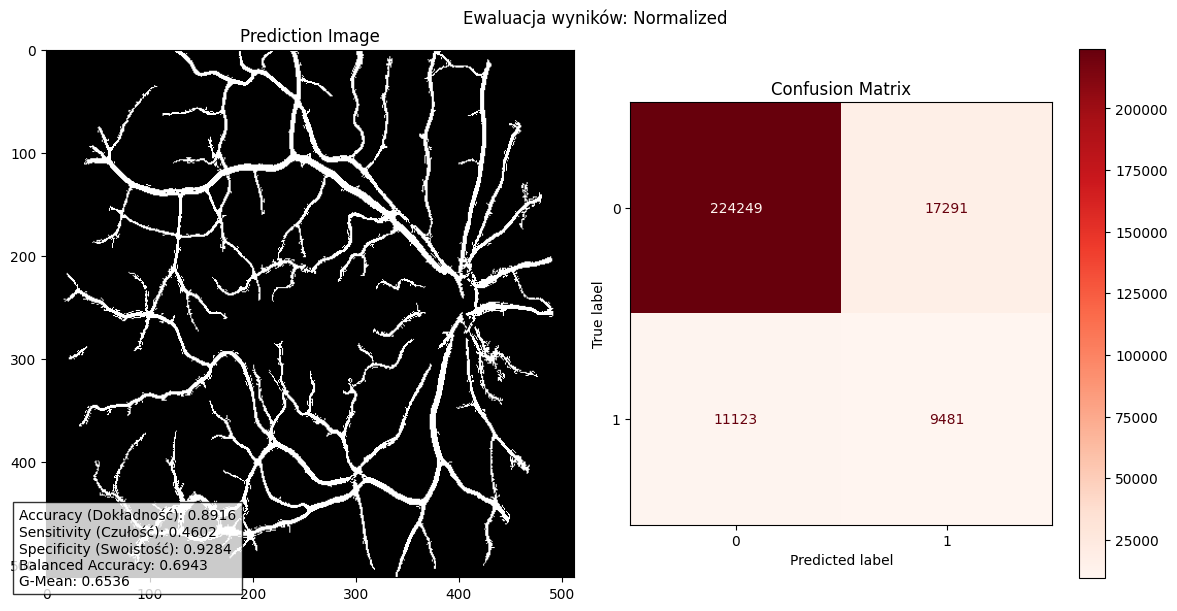

In [1]:
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, ConfusionMatrixDisplay
from tabulate import tabulate
import math
from scipy.stats import randint
from skimage import filters
from joblib import dump, load
import matplotlib.pyplot as plt
import os


PATCH_SIZE = (5,5)
IMAGE_SIZE = (512, 512)

def evaluate_segmentation(img_pred, img_true):

    # Sprawdzenie maksymalnych wartości
    print("Maksymalna wartość w predykcji:", img_pred.max())
    print("Maksymalna wartość w masce eksperckiej:", img_true.max())

    # Wizualizacja: Segmentacja vs Maska ekspercka
    fig_result = plt.figure(figsize=(12, 6))
    fig_result.suptitle('Porównanie przetwarzania vs maska ekspercka')

    # Segmentacja
    ax1 = fig_result.add_subplot(1, 2, 1)
    ax1.imshow(img_pred, cmap='gray')
    ax1.set_title("Obraz po przetwarzaniu")
    ax1.axis('off')

    # Maska ekspercka
    ax2 = fig_result.add_subplot(1, 2, 2)
    ax2.imshow(img_true, cmap='gray')
    ax2.set_title("Maska ekspercka")
    ax2.axis('off')

    fig_result.tight_layout()
    plt.show()

    # Normalizacja do zakresu [0, 1]
    y_true = img_true.ravel() / img_true.max()
    y_pred = img_pred.ravel() / img_pred.max()

    # Binaryzacja: naczynia = 1, tło = 0
    y_true_binary = (y_true > 0.5).astype(np.uint8)
    y_pred_binary = (y_pred > 0.5).astype(np.uint8)

    # Obliczenie metryk i macierzy pomyłek
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()

    # Accuracy (dokładność): ogólny odsetek poprawnych klasyfikacji
    accuracy = accuracy_score(y_true_binary, y_pred_binary)

    # Sensitivity (czułość / recall): jak dobrze wykrywane są naczynia (True Positive Rate)
    sensitivity = recall_score(y_true_binary, y_pred_binary)

    # Specificity (swoistość): jak dobrze wykrywane jest tło (True Negative Rate)
    specificity = tn / (tn + fp)

    # Balanced Accuracy: średnia czułości i swoistości (bardziej odporna na niezbalansowane dane)
    balanced_accuracy = (sensitivity + specificity) / 2

    # G-Mean: geometryczna średnia czułości i swoistości (karze nierównowagę)
    g_mean = math.sqrt(sensitivity * specificity)

    # Wyświetlenie metryk w tabeli
    headers = ["Method", "Accuracy", "Sensitivity", "Specificity", "Balanced Accuracy", "G-Mean"]
    data = [["Normalized", f"{accuracy:.4f}", f"{sensitivity:.4f}", f"{specificity:.4f}",
            f"{balanced_accuracy:.4f}", f"{g_mean:.4f}"]]
    print(tabulate(data, headers=headers, tablefmt="pipe"))

    # Wizualizacja wyników
    fig_result = plt.figure(figsize=(12, 6))
    fig_result.suptitle('Ewaluacja wyników: Normalized')

    # Obraz wynikowy
    ax_img = fig_result.add_subplot(1, 2, 1)
    ax_img.imshow(img_pred, cmap='gray')
    ax_img.set_title("Prediction Image")

    # Macierz pomyłek
    ax_cm = fig_result.add_subplot(1, 2, 2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax_cm, cmap='Reds', colorbar=True)
    ax_cm.set_title("Confusion Matrix")

    # Tekst z metrykami (opisowymi)
    metrics_text = (
        f"Accuracy (Dokładność): {accuracy:.4f}\n"
        f"Sensitivity (Czułość): {sensitivity:.4f}\n"
        f"Specificity (Swoistość): {specificity:.4f}\n"
        f"Balanced Accuracy: {balanced_accuracy:.4f}\n"
        f"G-Mean: {g_mean:.4f}"
    )
    fig_result.text(0.02, 0.02, metrics_text, fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()


def remove_small_objects(image, min_size=100):
    # Zakładamy: image = uint8 w skali 0–255
    _, binary = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY)  # lub użyj adaptive threshold
    
    # Connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    
    # Tworzymy maskę tylko dla dużych obiektów
    output = np.zeros_like(image)
    for i in range(1, num_labels):  # pomijamy tło (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            output[labels == i] = 255
    
    return output


def extract_features(image, shape_mask, step):

    features = []
    height, width = shape_mask.shape

    # Iterowanie chunkami 5x5 pikseli
    for y in range(0, height - PATCH_SIZE[0] + 1, step):
        for x in range(0, width - PATCH_SIZE[1] + 1, step):
            # Wydzielenie bloku obrazu w kolorze i skali szarości
            chunk = image[y:y + PATCH_SIZE[0], x:x + PATCH_SIZE[1]]
            chunk_mask = shape_mask[y:y + PATCH_SIZE[0], x:x + PATCH_SIZE[1]]

            moments = cv2.moments(chunk_mask)
            hu_moments = cv2.HuMoments(moments).flatten()

            mean = np.mean(chunk, axis=(0, 1))
            std = np.std(chunk, axis=(0, 1))
            

            # Połączenie wszystkich cech w jeden wektor
            feature_vector = np.hstack([mean, std, hu_moments])
            features.append(feature_vector)

    return features

def get_labels(image, step):

    labels = []
    height, width = image.shape

    # Iterowanie przez obraz w blokach o rozmiarze PATCH_SIZE x PATCH_SIZE
    for y in range(0, height - PATCH_SIZE[0] + 1, step):
        for x in range(0, width - PATCH_SIZE[1] + 1, step):
            patch = image[y:y + PATCH_SIZE[0], x:x + PATCH_SIZE[1]]
            label = patch[PATCH_SIZE[0] // 2, PATCH_SIZE[1] // 2]
            labels.append(label)

    return labels


def get_predicted_image(image, predicted):

    height, width = image.shape
    image = np.zeros((height, width))

    for y in range(0, height - PATCH_SIZE[0] + 1):
        for x in range(0, width - PATCH_SIZE[1] + 1):
            image[y:y + PATCH_SIZE[0], x:x + PATCH_SIZE[1]] = predicted[0]
            predicted = predicted[1:]

    return image

def train_model(start=1, end=10):

    features = []
    labels = [] 

    for image_nr in range(start, end + 1):
        print(f"Analiza zdjecia: {image_nr:02}")
        
        image = cv2.imread(f"./dane/obrazy/{image_nr:02}_h.jpg")
        if image is None:
            raise FileNotFoundError(f"Nie znaleziono pliku: ./dane/obrazy/{image_nr:02}_h.jpg")
        image = cv2.resize(image, IMAGE_SIZE[::-1])
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_green = img_rgb[:, :, 1]
        img_green = np.clip(img_green, 10, 245)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        normalized_image = clahe.apply(img_green)
        gray = filters.unsharp_mask(normalized_image)

        mask = cv2.imread(f"./dane/maski/{image_nr:02}_h_mask.tif")
        if mask is None:
            raise FileNotFoundError(f"Nie znaleziono pliku: ./dane/maski/{image_nr:02}_h_mask.tif")
        mask = cv2.resize(mask, IMAGE_SIZE[::-1])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask > 128
        gray[mask == 0] = 0

        # Wczytanie, przeskalowanie i maskowanie obrazu referencyjnego
        model = cv2.imread(f"./dane/naczynia/{image_nr:02}_h.tif")
        if model is None:
            raise FileNotFoundError(f"Nie znaleziono pliku: ./dane/naczynia/{image_nr:02}_h.tif")
        model = cv2.resize(model, IMAGE_SIZE[::-1])
        model = cv2.cvtColor(model, cv2.COLOR_BGR2GRAY)
        model = model > 128
        model[mask == 0] = 0

        print("Ekstrakcja cech i etykiet z obrazu")

        # Ekstrakcja cech i etykiet z obrazów
        features.extend(extract_features(image, gray, 1))
        labels.extend(get_labels(model, 1))

    features = np.array(features)
    labels = np.array(labels)

    print("Fitting model")

    # Zbalansowanie danych treningowych
    sampler = RandomUnderSampler(sampling_strategy=1)
    features, labels = sampler.fit_resample(features, labels)

    print("Train test split")

# Podział danych na zbiory treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Przestrzeń parametrów do losowego przeszukiwania
    param_dist = {
        'n_estimators': randint(100, 1000),
        'max_depth': [None] + list(range(5, 30, 5)),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2', None]
    }

    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    
    print("Starting RandomizedSearchCV")
    
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)

    print("Best params found:", random_search.best_params_)
    print("Best CV accuracy:", random_search.best_score_)

    best_model = random_search.best_estimator_

    accuracy = best_model.score(X_test, y_test)
    print("Test accuracy:", accuracy)

    # Zapisanie najlepszego modelu
    dump(best_model, "model.joblib")

# Wywołanie funkcji treningowej
if not os.path.exists("model.joblib"):
    print("Brak pliku modelu – rozpoczynam trening.")
    train_model()
else:
    print("Model już istnieje – pomijam trening.")

# tutaj dodaj sprawdzenie, czy istnieje, w innym wypadku exception
loaded_classifier = load("model.joblib")


def test_model(start=11, end=15):
    for image_nr in range(start, end + 1):
        image = cv2.imread(f"./dane/obrazy/{image_nr:02}_h.jpg")
        if image is None:
            raise FileNotFoundError(f"Nie znaleziono pliku: ./dane/obrazy/{image_nr:02}_h.jpg")
        image = cv2.resize(image, IMAGE_SIZE[::-1])
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_green = img_rgb[:, :, 1]
        img_green = np.clip(img_green, 10, 245)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        normalized_image = clahe.apply(img_green)
        gray = filters.unsharp_mask(normalized_image)

        mask = cv2.imread(f"./dane/maski/{image_nr:02}_h_mask.tif")
        if mask is None:
            raise FileNotFoundError(f"Nie znaleziono pliku: ./dane/maski/{image_nr:02}_h_mask.tif")
        mask = cv2.resize(mask, IMAGE_SIZE[::-1])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask > 128
        gray[mask == 0] = 0

        model = cv2.imread(f"./dane/naczynia/{image_nr:02}_h.tif")
        if model is None:
            raise FileNotFoundError(f"Nie znaleziono pliku: ./dane/naczynia/{image_nr:02}_h.tif")
        model = cv2.resize(model, IMAGE_SIZE[::-1])
        model = cv2.cvtColor(model, cv2.COLOR_BGR2GRAY)
        model = model > 128
        model[mask == 0] = 0

        classifier = loaded_classifier

        predictions = classifier.predict(extract_features(image, gray,1))

        print()
        print(f"Processed image: {image_nr:02}")
        predicted_image = get_predicted_image(gray, predictions)


        # LEKKI-POST-PROCESSING
        predicted_image = (predicted_image * 255).astype(np.uint8)
        predicted_image = remove_small_objects(predicted_image, min_size=40)

        # Wyświetlenie wszystkich obrazów obok siebie
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Oryginalny obraz')

        plt.subplot(1, 3, 2)
        plt.imshow(model, cmap='gray')
        plt.title('Ręcznie rysowana maska')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_image, cmap='gray')
        plt.title('Zrekonstruowana maska')

        predicted_for_eval = (predicted_image > 127).astype(np.uint8)


        # ==== COMPARING ===== 
        evaluate_segmentation(predicted_for_eval, model)



    plt.show()

test_model()

